# Assignment Two:  Sentiment Classification

For this exercise you will be using the "SemEval 2017 task 4" corpus provided on the module website, available through the following link: https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs918/semeval-tweets.tar.bz2 You will focus particularly on Subtask A, i.e. classifying the overall sentiment of a tweet as positive, negative or neutral.

You are requested to produce a Jupyter notebook for the coursework submission. The input to your program is the SemEval data downloaded. Note that TAs need to run your program on their own machine by using the original SemEval data. As such, don’t submit a Python program that takes as input some preprocessed files.

#### Import necessary packages
You may import more packages here.

In [1]:
# Import necessary packages
import re
from os.path import join
import numpy as np

import random

import nltk
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import contractions

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from collections import Counter

import demoji

from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import pipeline, set_seed

In [2]:
# device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

In [4]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    #id_gts = read_test(testset)
    file_path = join(folder_path, testset)
    id_gts = read_test(file_path)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

#### Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

In [5]:
# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

folder_path = 'semeval-tweets'

for dataset in ['twitter-training-data.txt'] + ['twitter-dev-data.txt'] + testsets: # With dev-data set
    data[dataset] = []
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []

    # write code to read in the datasets here
    file_path = join(folder_path, dataset)
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Split the line into parts using tab as the delimiter
            parts = line.strip().split('\t')
            
            # Ensure the line has 3 parts: tweet-id, sentiment, tweet-text
            if len(parts) == 3:
                tweet_id, sentiment, tweet_text = parts
                
                # Append the whole line to data
                data[dataset].append(line.strip())
                
                # Append individual parts to their respective lists
                tweetids[dataset].append(tweet_id)
                tweetgts[dataset].append(sentiment)
                tweets[dataset].append(tweet_text)

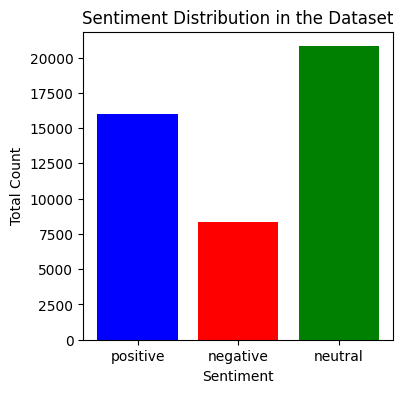

In [6]:
# Plot the distribution of sentiments in training data
sentiment_counts = Counter(tweetgts['twitter-training-data.txt'])
sentiments, counts = zip(*sentiment_counts.items())

plt.figure(figsize = (4, 4))
plt.bar(sentiments, counts, color = ['blue', 'red', 'green'])

plt.title('Sentiment Distribution in the Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Total Count')
plt.show()

#### Preprocessing

In [7]:
# Define regex patterns for cleaning tweets
patterns = [
    re.compile(r'https?://\S+'), # Remove URLs
    re.compile(r'@\w+'), # Remove @user mentions
    re.compile(r'[^a-zA-Z0-9 ]'), # Remove all non-alphanumeric characters except spaces
    re.compile(r'\b\w{1}\b'), # Remove words with only 1 character
    re.compile(r'\b\d+\b'), # Remove numbers that are fully made of digits
    re.compile(r'\b(?=\w*\d)(?=\w*[a-zA-Z])\w+\b') # Remove combination of digits and alphabets
]

# Function to clean tweets
def clean_tweets(dataset_key, patterns):
    cleaned_tweets = []
    
    for tweet in tweets[dataset_key]:
        # Convert the tweet to lowercase
        lower_tweet = tweet.lower() 

        # Replace emojis with description
        lower_tweet_emoji_desc = demoji.replace_with_desc(lower_tweet, sep = " ")

        expanded_words = []
        for word in lower_tweet_emoji_desc.split():
            # Expand contractions
            expanded_words.append(contractions.fix(word))
        expanded_text = ' '.join(expanded_words)

        # Apply each regex pattern
        for pattern in patterns:
            expanded_text = pattern.sub('', expanded_text)
            
        cleaned_tweets.append(expanded_text)
        
    return cleaned_tweets

In [8]:
processed_tweets = {}
dataset_keys = ['twitter-training-data.txt'] + ['twitter-dev-data.txt'] + testsets
for dataset_key in dataset_keys:
    processed_tweets[dataset_key] = clean_tweets(dataset_key, patterns)

#### Tokenization and Lemmatization

In [9]:
# Empty set for stop words
stop_words = set([None])

# Function to map NLTK's part-of-speech tags to wordnet's part-of-speech names
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to lemmatize a sentence
def lemmatize_sentence(sentence, stop_words):
    
    lemmatizer = WordNetLemmatizer()
    # Tokenize the sentence into words
    word_tokens = word_tokenize(sentence)
    # Get part-of-speech tags for each token
    pos_tags = pos_tag(word_tokens)
    
    # Lemmatize each word with the appropriate POS tag, excluding stop words
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags if word.lower() not in stop_words]
    
    return ' '.join(lemmatized_words), set(lemmatized_words)

In [10]:
%%time

lemmatized_tweets = {}
all_words = Counter()

training_dataset_key = 'twitter-training-data.txt'
dev_dataset_key = 'twitter-dev-data.txt'
dataset_keys = [training_dataset_key] + [dev_dataset_key] + testsets

for dataset_key in dataset_keys:
    lemmatized_texts = []
    for tweet in processed_tweets[dataset_key]:
        # Lemmatize tweet with returning both the lemmatized text and the set of unique lemmatized words
        lemmatized_text, lemmatized_words = lemmatize_sentence(tweet, stop_words)
        lemmatized_texts.append(lemmatized_text)
        # If processing training dataset, update the word count with the lemmatized words from the tweet
        if dataset_key == training_dataset_key:
            all_words.update(lemmatized_words)
    lemmatized_tweets[dataset_key] = lemmatized_texts

CPU times: total: 1min 38s
Wall time: 1min 38s


#### Vectorize

In [11]:
tfidf_vectorizer = TfidfVectorizer(
    max_features = 5000,
    min_df = 3
    )

X_train_tfidf = tfidf_vectorizer.fit_transform(lemmatized_tweets['twitter-training-data.txt'])
X_tests_tfidf = {}
for testset in testsets:
    X_test_tfidf = tfidf_vectorizer.transform(lemmatized_tweets[testset])
    X_tests_tfidf[testset] = X_test_tfidf

In [12]:
bow_vectorizer = CountVectorizer()

X_train_bow = bow_vectorizer.fit_transform(lemmatized_tweets['twitter-training-data.txt'])
X_tests_bow = {}
for testset in testsets:
    X_test_bow = bow_vectorizer.transform(lemmatized_tweets[testset])
    X_tests_bow[testset] = X_test_bow

In [13]:
y_train = tweetgts['twitter-training-data.txt']
y_tests = {}
for testset in testsets:
    y_test = tweetgts[testset]
    y_tests[testset] = y_test

#### SVM

In [14]:
def svm_training(X_train, y_train, features):

    if features == 'TFIDF':
        svc = LinearSVC(C = 1)
        svc.fit(X_train, y_train)
    elif features == 'bow':
        svc = LinearSVC(C = 1, max_iter = 5000)
        svc.fit(X_train, y_train)
    
    return svc

#### Naive Bayes

In [15]:
def nb_training(X_train, y_train, features):

    nb = MultinomialNB(alpha = 1)
    nb.fit(X_train, y_train)
    
    return nb

#### MaxEnt

In [16]:
def maxEnt_training(X_train, y_train, features):

    maxEnt = LogisticRegression(C = 1, max_iter = 1000)
    maxEnt.fit(X_train, y_train)
    
    return maxEnt

### LSTM

#### Mapping words to GloVe word embedding

In [17]:
# Build an index mapping words to their vector representation in GloVe word embeddings
glove_folder_path = 'glove.6B'
glove_file_path = join(glove_folder_path, 'glove.6B.100d.txt')

embedding_index = {}
with open(glove_file_path, 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embedding_index[word] = coefs

In [18]:
embedding_dim = 100
max_words = 5000
# Initialize the embedding matrix with zeros and shape of max_words x embedding_dim
embedding_matrix = np.zeros((max_words, embedding_dim))

words_not_found = 0

word_index = {}

# Iterate over words sorted by their frequency (most common first)
# Assign a unique index to words only found in the embedding index
# Then retrieve and assign the corresponding embedding vector to those words
for word, _ in all_words.most_common():
    if len(word_index) < 4998:
        if word in embedding_index:
            # Assign the next index to the word
            word_index[word] = len(word_index) + 1
            # Add the embedding vector to the matrix
            embedding_matrix[len(word_index)] = embedding_index[word]
    else:
        break

unk_index = len(word_index) + 1
# Add the <UNK> token to the word index
word_index['<UNK>'] = unk_index
# Set <UNK> to a zero vector
embedding_matrix[unk_index] = np.zeros((embedding_dim,))  

In [19]:
# Calculate the length of each tweet in the 'twitter-training-data.txt' dataset after lemmatization
lengths = [len(word_tokenize(tweet)) for tweet in lemmatized_tweets['twitter-training-data.txt']]

# Calculate the 95th percentile of these lengths to determine a cutoff point that includes 95% of the tweets
percentile_95 = np.percentile(lengths, 95)
max_length = int(np.ceil(percentile_95))
print(f"Choosing a max_length of {max_length} will cover 95% of the tweets.")

Choosing a max_length of 25 will cover 95% of the tweets.


In [20]:
# Function to convert tweets to sequences
def tweets_to_sequences(tweets, word_index):
    sequences = []
    unk_token = "<UNK>"
    
    for tweet in tweets:
        words = tweet.split()
        
        # Convert each word to its index if present in `word_index`; use `<UNK>` index otherwise
        sequence = [word_index.get(word, word_index.get(unk_token, 0)) for word in words]
        
        sequences.append(sequence)
    
    return sequences

sequences_tweets_training = tweets_to_sequences(lemmatized_tweets['twitter-training-data.txt'], word_index)
sequences_tweets_validation  = tweets_to_sequences(lemmatized_tweets['twitter-dev-data.txt'], word_index)
sequences_tweets_tests = {}
for testset in testsets:
    sequences = tweets_to_sequences(lemmatized_tweets[testset], word_index)
    sequences_tweets_tests[testset] = sequences

In [21]:
# PyTorch class tailored for handling sequences of tweets
class TweetDataset(Dataset):

    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype = torch.long)
        label = torch.tensor(self.labels[idx], dtype = torch.long)
        return sequence, label

In [22]:
# Parameters of LSTM training
embedding_dim = 100
hidden_dim = 1024
learning_rate = 0.001
batch_size = 64
num_epochs = 100
dropout = 0.4

In [23]:
# Preparing training, validation, and test datasets 

# Mapping textual sentiment labels to numerical labels
sentiment_label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Training
X_train = pad_sequences(sequences_tweets_training, maxlen = max_length)
y_train = tweetgts['twitter-training-data.txt']
y_train_numerical = [sentiment_label_mapping[label] for label in y_train]
training_dataset = TweetDataset(X_train, y_train_numerical)
training_dataloader = DataLoader(training_dataset, batch_size = batch_size, shuffle = True)

# Validation
X_validation = pad_sequences(sequences_tweets_validation, maxlen = max_length)
y_validation = tweetgts['twitter-dev-data.txt']
y_validation_numerical = [sentiment_label_mapping[label] for label in y_validation]
validation_dataset = TweetDataset(X_validation, y_validation_numerical)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False)

# Testing
testing_dataloaders = {}
for testset in testsets:
    X_test = pad_sequences(sequences_tweets_tests[testset], maxlen = max_length)
    y_test = tweetgts[testset]
    y_test_numerical = [sentiment_label_mapping[label] for label in y_test]
    testing_dataset = TweetDataset(X_test, y_test_numerical)
    testing_dataloader = DataLoader(testing_dataset, batch_size = batch_size, shuffle = False)
    testing_dataloaders[testset] = testing_dataloader

In [24]:
# Define the Attention layer in LSTM model
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(hidden_dim * 2, 1)
    
    def forward(self, lstm_output):
        attention_scores = self.linear(lstm_output).squeeze(2)
        # Apply softmax to attention scores
        attention_weights = torch.softmax(attention_scores, dim = 1).unsqueeze(2)    
        context_vector = torch.sum(attention_weights * lstm_output, dim = 1)
        return context_vector, attention_weights

# Define the LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, max_words, embedding_dim, hidden_dim, embedding_matrix, num_classes = 3, dropout_rate = dropout):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(max_words, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
        self.embedding.weight.requires_grad = False # Freeze the embedding layer
        self.dropout = nn.Dropout(dropout_rate)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True, bidirectional = True) #bidirectional LSTM
        self.attention = Attention(hidden_dim)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        context_vector, attention_weights = self.attention(lstm_out)
        context_vector = self.dropout(context_vector)
        output = self.classifier(context_vector)
        return output

# Initialize the model
lstm_model = SentimentLSTM(
    max_words=max_words, 
    embedding_dim=embedding_dim, 
    hidden_dim=hidden_dim, 
    embedding_matrix=embedding_matrix
).to(device)

# Define the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
# Define the optimizer as Adam with L2 regularization
optimizer = optim.Adam(lstm_model.parameters(), lr = learning_rate, weight_decay = 1e-5)

In [25]:
# Early Stopping Parameters
early_stopping_patience = 2
early_stopping_counter = 0
best_val_loss = float('inf')

train_losses = []
val_losses = []

# Training and Validation Loop
for epoch in range(num_epochs):
    
    # Training part
    lstm_model.train()
    train_loss = 0.0
    for tweets_text, sentiments in tqdm(training_dataloader, desc=f'Epoch {epoch+1}', leave=False):
        tweets_text = tweets_text.to(device).long()
        sentiments = sentiments.to(device).long()
        
        optimizer.zero_grad()
        outputs = lstm_model(tweets_text.long())
        loss = criterion(outputs, sentiments)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    lstm_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for tweets_text, sentiments in validation_dataloader:
            tweets_text = tweets_text.to(device).long()
            sentiments = sentiments.to(device).long()
            
            outputs = lstm_model(tweets_text.long())
            loss = criterion(outputs, sentiments)
            val_loss += loss.item()
    
    # Calculate losses
    train_loss /= len(training_dataloader)
    val_loss /= len(validation_dataloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(lstm_model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Triggered early stopping.")
            break

Epoch 1, Train Loss: 0.8841, Val Loss: 0.8118


Epoch 2, Train Loss: 0.8404, Val Loss: 0.7893


Epoch 3, Train Loss: 0.8241, Val Loss: 0.7803


Epoch 4, Train Loss: 0.8095, Val Loss: 0.7696


Epoch 5, Train Loss: 0.7940, Val Loss: 0.7639


Epoch 6, Train Loss: 0.7775, Val Loss: 0.7410


Epoch 7, Train Loss: 0.7637, Val Loss: 0.7390


Epoch 8, Train Loss: 0.7524, Val Loss: 0.7314


Epoch 9, Train Loss: 0.7420, Val Loss: 0.7393


Epoch 10, Train Loss: 0.7292, Val Loss: 0.7169


Epoch 11, Train Loss: 0.7232, Val Loss: 0.7240


Epoch 12, Train Loss: 0.7116, Val Loss: 0.7151


Epoch 13, Train Loss: 0.7018, Val Loss: 0.7110


Epoch 14, Train Loss: 0.6935, Val Loss: 0.7159


Epoch 15, Train Loss: 0.6819, Val Loss: 0.7075


Epoch 16, Train Loss: 0.6723, Val Loss: 0.7180


Epoch 17, Train Loss: 0.6600, Val Loss: 0.7122
Triggered early stopping.


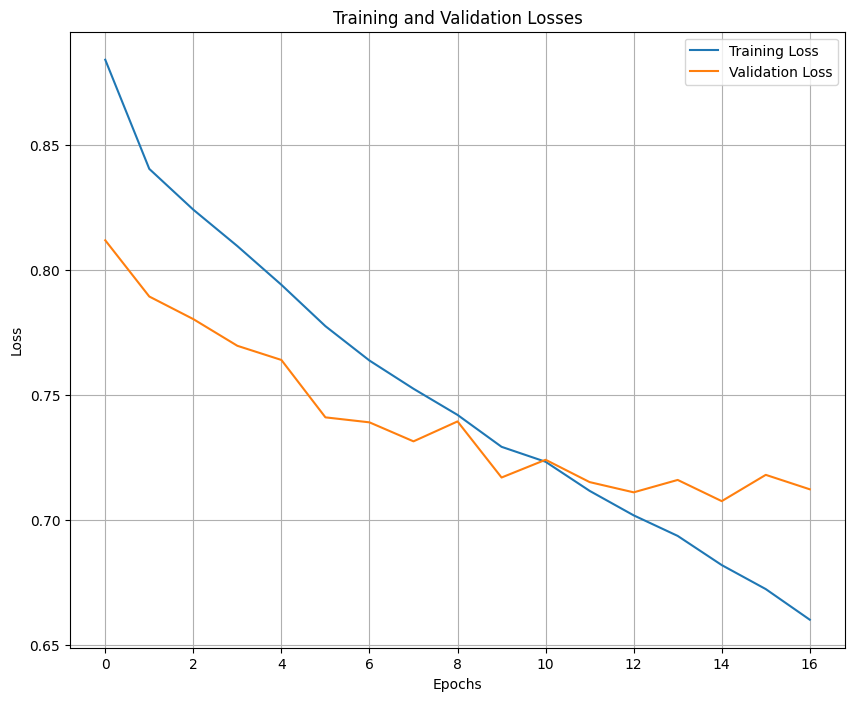

In [26]:
# Plotting the training and validation losses
plt.figure(figsize = (10, 8))
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Evaluates the model's performance on a given dataset
def evaluate_model(dataloader, tweet_ids):
    lstm_model.eval()
    true_sentiments = []
    predicted_sentiments = []

    with torch.no_grad():
        for tweets, sentiments in dataloader:
            tweets = tweets.to(device).long()
            sentiments = sentiments.to(device).long()
            outputs = lstm_model(tweets)
            predictions = torch.argmax(outputs, dim = 1)
            
            true_sentiments.extend(sentiments.cpu().numpy())
            predicted_sentiments.extend(predictions.cpu().numpy())

    # Mapping from numerical labels back to textual sentiment labels
    sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_labels = [sentiment_labels[predict] for predict in predicted_sentiments]
    
    id_preds = dict(zip(tweetids[tweet_ids], predicted_labels))

    testset_path = join('semeval-tweets', tweet_ids)

    features = 'GloVe Embeddings'
    classifier = 'LSTM'
    
    # Call the evaluate function
    evaluate(id_preds, testset_path, features + '-' + classifier)
    confusion(id_preds, tweet_ids, features + '-' + classifier)

for testset, dataloader in testing_dataloaders.items():
     evaluate_model(dataloader, testset)

semeval-tweets\twitter-test1.txt (GloVe Embeddings-LSTM): 0.636
            positive  negative  neutral
positive    0.777     0.040     0.182     
negative    0.124     0.773     0.102     
neutral     0.242     0.130     0.628     

semeval-tweets\twitter-test2.txt (GloVe Embeddings-LSTM): 0.642
            positive  negative  neutral
positive    0.820     0.028     0.152     
negative    0.096     0.798     0.106     
neutral     0.327     0.102     0.570     

semeval-tweets\twitter-test3.txt (GloVe Embeddings-LSTM): 0.574
            positive  negative  neutral
positive    0.780     0.042     0.178     
negative    0.163     0.588     0.249     
neutral     0.293     0.132     0.575     



#### Build sentiment classifiers
You need to create your own classifiers (at least 3 classifiers). For each classifier, you can choose between the bag-of-word features and the word-embedding-based features. Each classifier has to be evaluated over 3 test sets. Make sure your classifier produce consistent performance across the test sets. Marking will be based on the performance over all 5 test sets (2 of them are not provided to you).

In [28]:
# Build the id_preds needed for function evaluate()
def train_and_predict(model_training, features, testset):

    X_train = None
    X_test = None
    
    if features == 'TFIDF':
        X_train = X_train_tfidf
        X_test = X_tests_tfidf[testset]
    elif features == 'bow':
        X_train = X_train_bow
        X_test = X_tests_bow[testset]

    model = model_training(X_train, y_train, features)
    
    tweet_ids = tweetids[testset]
    
    # Generate predictions
    predictions = model.predict(X_test)
    
    # Map predictions to tweet IDs
    id_preds = dict(zip(tweet_ids, predictions))
    
    return id_preds

In [29]:
# Buid traditional sentiment classifiers. An example classifier name 'svm' is given
# in the code below. You should replace the other two classifier names
# with your own choices. For features used for classifier training, 
# the 'bow' feature is given in the code. But you could also explore the 
# use of other features.
for classifier in ['svm', 'nb', 'MaxEnt']:
    for features in ['bow', 'TFIDF']:
        # Skeleton: Creation and training of the classifiers
        if classifier == 'svm':

            model = svm_training
            
            print('Training ' + classifier)
            
        elif classifier == 'nb':

            model = nb_training
            
            print('Training ' + classifier)
        elif classifier == 'MaxEnt':
            # write the classifier 3 here

            model = maxEnt_training
            
            print('Training ' + classifier)
        # elif classifier == 'LSTM':
        #     # write the LSTM classifier here
        #     if features == 'bow':
        #         continue
        #     print('Training ' + classifier)
        else:
            print('Unknown classifier name' + classifier)
            continue

        # Predition performance of the classifiers
        for testset in testsets:
            id_preds = {}
            # write the prediction and evaluation code here
            id_preds = train_and_predict(model, features, testset)
            #confusion(id_preds, testset, classifier)

            testset_name = testset
            testset_path = join('semeval-tweets', testset_name)
            evaluate(id_preds, testset_path, features + '-' + classifier)

Training svm
semeval-tweets\twitter-test1.txt (bow-svm): 0.535
semeval-tweets\twitter-test2.txt (bow-svm): 0.564
semeval-tweets\twitter-test3.txt (bow-svm): 0.503
Training svm
semeval-tweets\twitter-test1.txt (TFIDF-svm): 0.581
semeval-tweets\twitter-test2.txt (TFIDF-svm): 0.602
semeval-tweets\twitter-test3.txt (TFIDF-svm): 0.542
Training nb
semeval-tweets\twitter-test1.txt (bow-nb): 0.496
semeval-tweets\twitter-test2.txt (bow-nb): 0.461
semeval-tweets\twitter-test3.txt (bow-nb): 0.496
Training nb
semeval-tweets\twitter-test1.txt (TFIDF-nb): 0.400
semeval-tweets\twitter-test2.txt (TFIDF-nb): 0.431
semeval-tweets\twitter-test3.txt (TFIDF-nb): 0.401
Training MaxEnt
semeval-tweets\twitter-test1.txt (bow-MaxEnt): 0.574
semeval-tweets\twitter-test2.txt (bow-MaxEnt): 0.573
semeval-tweets\twitter-test3.txt (bow-MaxEnt): 0.536
Training MaxEnt
semeval-tweets\twitter-test1.txt (TFIDF-MaxEnt): 0.571
semeval-tweets\twitter-test2.txt (TFIDF-MaxEnt): 0.581
semeval-tweets\twitter-test3.txt (TFIDF-Max

In [30]:
def classify_tweets(test_file):
    # Use bart-large model with trained on the MultiNLI (MNLI) dataset
    classifier = pipeline("zero-shot-classification", model = "facebook/bart-large-mnli")
    candidate_labels = ["positive", "negative", "neutral"]

    text = tweets[test_file]
    max_labels = []

    for tweet in tqdm(text, desc = f"Processing {test_file}"):
        result = classifier(tweet, candidate_labels)
        max_label = max(zip(result['labels'], result['scores']), key=lambda pair: pair[1])[0]
        max_labels.append(max_label)

    # Writing results to a file
    output_file = f'BART-{test_file}'
    with open(output_file, 'w') as f:
        for label in max_labels:
            f.write(f"{label}\n")

    print(f"Finished writing labels to {output_file}.")

classify_tweets('twitter-test1.txt')
classify_tweets('twitter-test2.txt')
classify_tweets('twitter-test3.txt')

Processing twitter-test1.txt: 100%|████████████████████████████████████████████████| 3531/3531 [27:55<00:00,  2.11it/s]


Finished writing labels to BART-twitter-test1.txt.


Processing twitter-test2.txt: 100%|████████████████████████████████████████████████| 1853/1853 [14:09<00:00,  2.18it/s]


Finished writing labels to BART-twitter-test2.txt.


Processing twitter-test3.txt: 100%|████████████████████████████████████████████████| 2379/2379 [17:53<00:00,  2.22it/s]

Finished writing labels to BART-twitter-test3.txt.


In [37]:
#  Evaluate BART model predictions 
def evaluate_bart_results(test_file):

    BART_preds = []
    bart_file = f'BART-{test_file}'

    with open(bart_file, 'r') as file:
        for line in file:
            prediction = line.strip()
            BART_preds.append(prediction)

    id_preds = dict(zip(tweetids[test_file], BART_preds))
    evaluate(id_preds, join('semeval-tweets', test_file), 'BART')

evaluate_bart_results('twitter-test1.txt')
evaluate_bart_results('twitter-test2.txt')
evaluate_bart_results('twitter-test3.txt')

semeval-tweets\twitter-test1.txt (BART): 0.620
semeval-tweets\twitter-test2.txt (BART): 0.635
semeval-tweets\twitter-test3.txt (BART): 0.600
